# 1. Prepare data

res = (420, 236), n_data = 99120
data.shape = torch.Size([1, 99120])
uv.shape = torch.Size([1, 99120])


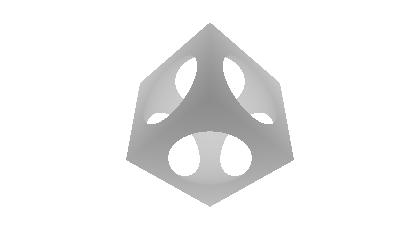

In [55]:
import torch
import torch.nn as nn
import torch.functional as F
from torchvision import transforms
import torchvision
from PIL import Image
import numpy as np

data_img = Image.open("./test_small.png")
res = data_img.size
n_data = res[0] * res[1]
print(f"res = {res}, n_data = {n_data}")

# data = torch.reshape(
#     torch.transpose(
#         transforms.ToTensor()(data_img)[0], 0, 1),
#         (res[0] * res[1], 1))
data_img_tensor = transforms.ToTensor()(data_img)[0]

data = torch.reshape(
        data_img_tensor,
        (1, n_data))

print(f"data.shape = {data.shape}")

# uv = np.mgrid[0:res[0]:1, 0:res[1]:1].reshape(2,-1).T
# uv = torch.Tensor(uv).to(torch.long)
# print(uv.shape)

uv = torch.reshape(
    torch.Tensor(np.array(range(0, res[0]*res[1]))),
    (1, n_data))

print(f"uv.shape = {uv.shape}")

transforms.ToPILImage()(data_img_tensor)

# 2. Train MLP
### (However, the input to this MLP is too high dimensional to use in practice. )

In [58]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

class sdf_net(nn.Module):
    def __init__(self):
        super(sdf_net, self).__init__()

        self.linear_relu_stack = nn.Sequential(
            nn.Linear(n_data, 3),
            nn.ReLU(),
            nn.Linear(3, 3),
            nn.ReLU(),
            nn.Linear(3, n_data, bias=False)
        )
    
    def forward(self, x):
        x = self.linear_relu_stack(x)
        return x 

model = sdf_net().to(device)
loss_fn = nn.MSELoss(reduction='mean')
# loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
uv = uv.to(device)
data =data.to(device)

def train(model, loss_fn, optimizer):

    pred = model(uv)
    loss = loss_fn(pred, data)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss

max_iter = 2000
loss_list = []

for t in range(max_iter):
    loss = train(model, loss_fn, optimizer)
    loss_list.append(loss)
    if t % 100 == 0:
        print(f"{t}: {loss}")

Using cuda device
0: 24529268.0
100: 0.8849155902862549
200: 0.7647203207015991
300: 0.5980339050292969
400: 0.4258202612400055
500: 0.28036099672317505
600: 0.17378680408000946
700: 0.10295289009809494
800: 0.058725059032440186
900: 0.03238281235098839
1000: 0.01741539128124714
1100: 0.009118580259382725
1200: 0.0046670143492519855
1300: 0.0023540931288152933
1400: 0.001170008210465312
1500: 0.0005686209769919515
1600: 0.00027504359604790807
1700: 0.0001284606842091307
1800: 6.023596506565809e-05
1900: 2.6549523681751452e-05


In [59]:
fit = model(uv).cpu().detach()
print(fit)

(fit - data.cpu().detach()).norm()

tensor([[1.0008, 1.0008, 0.9999,  ..., 1.0009, 1.0009, 1.0003]])


tensor(1.0888)

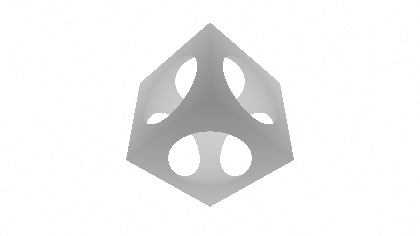

In [60]:
fit = torch.reshape(
    fit,
    (res[1], res[0])
)

fit_to_pil_img = transforms.ToPILImage()(fit)
fit_to_pil_img

In [61]:
torch.save(model.state_dict(), "./MLP.pt")

In [62]:
model.load_state_dict(torch.load("./MLP.pt"))

<All keys matched successfully>

In [85]:
min1 = min2 = 0
max1 = max2 = 0

layer1_param = layer2_param = 0

for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)
        if name == "linear_relu_stack.0.weight":
            p = param.data.cpu().detach()
            layer1_param = p
            print("before: ", torch.max(p), torch.min(p))

            p = torch.reshape(
                p,
            (3, res[1], res[0])
            ) 
            
            # normalization 
            min1 = torch.min(p)
            print(min1)
            p += abs(torch.min(p))

            max1 = torch.max(p)
            print(max1)
            p /= (torch.max(p)) 

            print("after: ", torch.max(p), torch.min(p))

            param_img = transforms.ToPILImage()(p)
            # param_img.show()
            param_img.save("./linear_relu_stack_0_weight.png")

        if name == "linear_relu_stack.4.weight":
            p = param.data.cpu().detach()
            layer2_param = p

            print("before: ", torch.max(p), torch.min(p))

            p = torch.reshape(
                p,
            (3, res[1], res[0])
            ) 

            # normalization 
            min2 = torch.min(p)
            print(min2)
            p += abs(torch.min(p))

            max2 = torch.max(p)
            print(max2)
            p /= (torch.max(p))

            print("after: ", torch.max(p), torch.min(p))

            param_img = transforms.ToPILImage()(p)
            print(torch.max(p), torch.min(p))
            # param_img.show()
            param_img.save("./linear_relu_stack_4_weight.png")

linear_relu_stack.0.weight tensor([[ 0.0003,  0.0018, -0.0017,  ..., -0.0028,  0.0014,  0.0007],
        [ 0.0007,  0.0011, -0.0013,  ...,  0.0025, -0.0020, -0.0010],
        [ 0.0023, -0.0070, -0.0076,  ..., -0.0061, -0.0053, -0.0042]],
       device='cuda:0')
before:  tensor(0.0032) tensor(-0.0092)
tensor(-0.0092)
tensor(0.0124)
after:  tensor(1.) tensor(0.)
linear_relu_stack.0.bias tensor([ 0.0027, -0.0004, -0.0039], device='cuda:0')
linear_relu_stack.2.weight tensor([[ 0.5635,  0.3977,  0.0645],
        [-0.3724,  0.4793, -0.3622],
        [ 0.2269,  0.4112,  0.4106]], device='cuda:0')
linear_relu_stack.2.bias tensor([0.2952, 1.4025, 0.4366], device='cuda:0')
linear_relu_stack.4.weight tensor([[ 0.1126,  0.8344, -0.4642],
        [-0.5772,  0.7928,  0.1355],
        [ 0.2984,  0.6146,  0.1139],
        ...,
        [ 0.2483,  0.6160,  0.1454],
        [-0.0713,  0.7442, -0.0496],
        [ 0.1322,  0.7950, -0.3516]], device='cuda:0')
before:  tensor(1.0105) tensor(-0.5833)
tensor(-

In [93]:
param1 = Image.open("./linear_relu_stack_0_weight.png")
param1_tensor = transforms.ToTensor()(param1)
p = torch.reshape(param1_tensor, (3, res[1]* res[0])) * max1 - abs(min1)
p


tensor([[ 0.0003,  0.0017, -0.0017,  ..., -0.0029,  0.0014,  0.0007],
        [ 0.0007,  0.0011, -0.0013,  ...,  0.0024, -0.0021, -0.0010],
        [ 0.0023, -0.0070, -0.0076,  ..., -0.0061, -0.0053, -0.0042]])

In [84]:
param2 = Image.open("./linear_relu_stack_4_weight.png")
param2_tensor = transforms.ToTensor()(param2)
p = torch.reshape(param2_tensor, (res[1]* res[0],3)) * max2 - abs(min2)
p

tensor([[ 0.1105,  0.8292, -0.4646],
        [-0.5833,  0.7917,  0.1355],
        [ 0.2980,  0.6105,  0.1105],
        ...,
        [ 0.2480,  0.6105,  0.1417],
        [-0.0770,  0.7417, -0.0520],
        [ 0.1292,  0.7917, -0.3520]])